In [1]:
!pip install openai pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 17.8 MB/s eta 0:00:00


In [2]:
#Step #1 - Normal Text based Retrieval
import os
import time
import json
from openai import OpenAI
import fitz  # PyMuPDF
from typing import Dict, Tuple, List
from datetime import datetime
from collections import defaultdict

class PDFAnalyzer:
    def __init__(self, api_key: str, model: str = "gpt-4o-mini"):
        self.client = OpenAI(api_key=api_key)
        self.model = model

        # Define categories with specific metrics to look for
        self.categories = {
            "Macro environment": ["market conditions", "economic factors", "industry trends"],
            "Pricing": ["pricing strategies", "rate changes", "price pressure"],
            "Margins": ["operating margin", "gross margin", "profit margin"],
            "Bookings/Large Deals": ["TCV", "deal size", "contract value"],
            "Discretionary/Small Deals": ["small deal performance", "discretionary spending"],
            "People": ["headcount", "attrition", "hiring"],
            "Cloud": ["cloud revenue", "cloud adoption", "cloud services"],
            "Security": ["security initiatives", "cybersecurity", "data protection"],
            "Gen AI": ["AI investments", "AI adoption", "AI capabilities"],
            "M&A": ["acquisitions", "mergers", "deal values"],
            "Investments": ["capital allocation", "investment focus", "spending"],
            "Partnerships": ["strategic alliances", "ecosystem partners"],
            "Technology Budget": ["tech spending", "IT budget", "digital investments"],
            "Product/IP/Assets": ["product portfolio", "IP development", "assets"],
            "Talent/Training": ["skill development", "training programs", "talent metrics"],
            "Clients": ["client wins", "customer base", "client satisfaction"],
            "Awards/Recognition": ["industry recognition", "awards", "rankings"]
        }

    def retry_with_backoff(self, func, *args, max_retries=5, initial_delay=1):
        """Execute a function with exponential backoff retry logic."""
        retries = 0
        delay = initial_delay

        while retries < max_retries:
            try:
                return func(*args)
            except Exception as e:
                retries += 1
                if retries == max_retries:
                    raise e

                if "429" in str(e) or "rate_limit" in str(e).lower():
                    wait_time = delay * (2 ** (retries - 1))  # Exponential backoff
                    print(f"\nRate limit hit. Waiting {wait_time} seconds before retry {retries}/{max_retries}...")
                    time.sleep(wait_time)
                    continue
                else:
                    raise e

    def generate_content_with_retry(self, prompt: str) -> str:
        """Generate content with retry logic using OpenAI API."""
        def _generate():
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": "You are a financial analyst expert at analyzing earnings call transcripts. Your main task is to extract EXACT VERBATIM quotes with page numbers. Include the company name and focus on extracting specific statements with exact numbers, metrics, and factual information."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.2,  # Lower temperature for more precise extraction
                max_tokens=1500
            )
            return response.choices[0].message.content

        return self.retry_with_backoff(_generate)

    def analyze_page(self, text: str, page_num: int) -> Dict:
        """Analyze a single page of text with focus on extracting verbatim quotes."""
        try:
            analysis_prompt = f"""Analyze this page (Page {page_num}) of an earnings call transcript.

            PRIMARY TASK: Extract EXACT VERBATIM quotes for each relevant category. These must be word-for-word extracts from the text, not summaries or interpretations.

            Format the response as JSON:
            {{
                "page_number": {page_num},
                "company_name": "extracted from text if available",
                "categories": {{
                    "category_name": {{
                        "verbatim_quotes": [
                            {{
                                "quote": "EXACT word-for-word quote from the text",
                                "page": {page_num}
                            }}
                        ]
                    }}
                }}
            }}

            Categories to analyze:
            {json.dumps(self.categories, indent=2)}

            Text to analyze:
            {text}

            Rules:
            1. Only include categories that are actually mentioned on this page
            2. EXTRACT EXACT QUOTES - do not paraphrase or summarize
            3. Include the page number with each quote
            4. Focus on quotes containing specific numbers, percentages, and financial metrics
            5. Prioritize statements made by executives (CEO, CFO, etc.)
            6. Extract company name if mentioned on this page"""

            # Get analysis with retry logic
            response_text = self.generate_content_with_retry(analysis_prompt)

            try:
                # Extract JSON from response
                json_start = response_text.find('{')
                json_end = response_text.rfind('}') + 1

                if json_start >= 0 and json_end > json_start:
                    json_str = response_text[json_start:json_end]
                    # Clean up formatting
                    json_str = json_str.replace('```json', '').replace('```', '')
                    return json.loads(json_str)

                return {
                    "page_number": page_num,
                    "categories": {},
                    "raw_text": response_text
                }

            except json.JSONDecodeError as e:
                print(f"JSON parsing error on page {page_num}: {str(e)}")
                print("Raw response:", response_text[:200])
                return {
                    "page_number": page_num,
                    "error": str(e),
                    "raw_text": response_text
                }

        except Exception as e:
            print(f"Error analyzing page {page_num}: {str(e)}")
            return {
                "page_number": page_num,
                "error": str(e)
            }

    def analyze_pdf(self, pdf_path: str) -> Dict:
        """Analyze PDF page by page with focus on extracting verbatim quotes."""
        try:
            # Open PDF
            doc = fitz.open(pdf_path)
            print(f"\nProcessing PDF: {pdf_path}")
            print(f"Total pages: {len(doc)}")

            # Generate base filename for results
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            base_filename = f"verbatim_analysis_{timestamp}"

            # Create directory for intermediate results
            os.makedirs("analysis_results", exist_ok=True)

            # Store results for each page
            page_results = []

            # Aggregated quotes by category
            all_verbatim_quotes = defaultdict(list)
            company_name = ""

            # Process each page
            for page_num in range(len(doc)):
                print(f"\nProcessing page {page_num + 1}/{len(doc)}...")

                # Get page text
                page = doc[page_num]
                text = page.get_text()

                # Clean up text - preserve paragraphs but remove extra whitespace
                text = '\n'.join([' '.join(line.split()) for line in text.split('\n') if line.strip()])

                # Analyze page
                page_analysis = self.analyze_page(text, page_num + 1)
                page_results.append(page_analysis)

                # Extract company name if available and not already set
                if not company_name and "company_name" in page_analysis and page_analysis["company_name"]:
                    company_name = page_analysis["company_name"]

                # Aggregate verbatim quotes from this page
                if "categories" in page_analysis:
                    for category, data in page_analysis["categories"].items():
                        if "verbatim_quotes" in data:
                            all_verbatim_quotes[category].extend(data["verbatim_quotes"])

                # Save intermediate results after each page
                intermediate_results = {
                    "metadata": {
                        "timestamp": datetime.now().isoformat(),
                        "filename": pdf_path,
                        "company_name": company_name,
                        "total_pages": len(doc),
                        "processed_pages": len(page_results),
                        "model": self.model,
                        "analysis_version": "2.0"
                    },
                    "page_analysis": page_results,
                    "aggregated_verbatim_quotes": dict(all_verbatim_quotes)
                }

                intermediate_file = os.path.join("analysis_results", f"{base_filename}_intermediate.json")
                with open(intermediate_file, 'w', encoding='utf-8') as f:
                    json.dump(intermediate_results, f, indent=2, ensure_ascii=False)

            # Prepare final results
            final_results = {
                "metadata": {
                    "timestamp": datetime.now().isoformat(),
                    "filename": pdf_path,
                    "company_name": company_name,
                    "total_pages": len(doc),
                    "processed_pages": len(page_results),
                    "model": self.model,
                    "analysis_version": "2.0"
                },
                "page_analysis": page_results,
                "aggregated_verbatim_quotes": dict(all_verbatim_quotes)
            }

            # Save final results
            output_file = os.path.join("analysis_results", f"{base_filename}_final.json")
            with open(output_file, 'w', encoding='utf-8') as f:
                json.dump(final_results, f, indent=2, ensure_ascii=False)

            print(f"\nVerbatim analysis saved to: {output_file}")
            return final_results

        except Exception as e:
            print(f"Error analyzing PDF: {str(e)}")
            return {"error": str(e)}

    def generate_verbatim_summary(self, results: Dict, save_to_file: bool = True) -> str:
        """Generate a summary based on verbatim quotes with page references."""
        try:
            company_name = results.get("metadata", {}).get("company_name", "")

            summary_prompt = f"""Create a comprehensive summary of this earnings call analysis based EXCLUSIVELY on the verbatim quotes.
            Each point must be backed by an exact quote with its page number.

            Company Name: {company_name}

            Verbatim quotes by category:
            {json.dumps(results['aggregated_verbatim_quotes'], indent=2)}

            Format the summary with:
            # {company_name} Earnings Call Analysis

            ## Key Financial Metrics
            - [EXACT QUOTE] (Page X)
            - [EXACT QUOTE] (Page X)

            ## Operational Highlights
            - [EXACT QUOTE] (Page X)
            - [EXACT QUOTE] (Page X)

            ## Strategic Initiatives
            - [EXACT QUOTE] (Page X)
            - [EXACT QUOTE] (Page X)

            ## Market Conditions
            - [EXACT QUOTE] (Page X)
            - [EXACT QUOTE] (Page X)

            ## Future Outlook
            - [EXACT QUOTE] (Page X)
            - [EXACT QUOTE] (Page X)

            Rules:
            1. Use ONLY the provided verbatim quotes - do not add any interpretations
            2. Include page references for ALL quotes
            3. Focus on the most significant quotes with specific numbers and metrics
            4. Organize by topic area, not by original category
            5. If possible, identify the time period covered by the earnings call (e.g., Q3 2024)"""

            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": "You are a financial analyst expert at summarizing earnings calls using exact verbatim quotes with page references."},
                    {"role": "user", "content": summary_prompt}
                ],
                temperature=0.2,
                max_tokens=1500
            )
            summary_text = response.choices[0].message.content

            if save_to_file:
                # Generate timestamp for the filename
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                summary_filename = os.path.join("analysis_results", f"verbatim_summary_{timestamp}.md")

                # Create the directory if it doesn't exist
                os.makedirs("analysis_results", exist_ok=True)

                # Save the summary to file
                with open(summary_filename, 'w', encoding='utf-8') as f:
                    f.write(summary_text)
                print(f"\nVerbatim summary saved to: {summary_filename}")

            return summary_text

        except Exception as e:
            error_msg = f"Error generating verbatim summary: {str(e)}"
            if save_to_file:
                error_filename = os.path.join("analysis_results", "verbatim_summary_error.txt")
                with open(error_filename, 'w', encoding='utf-8') as f:
                    f.write(error_msg)
                print(f"\nError log saved to: {error_filename}")
            return error_msg

    def generate_insight_report(self, results: Dict, save_to_file: bool = True) -> str:
        """Generate insights based on verbatim quotes while maintaining the original context."""
        try:
            company_name = results.get("metadata", {}).get("company_name", "")

            insight_prompt = f"""Create an insight report based ONLY on the verbatim quotes from this earnings call.

            Company Name: {company_name}

            Verbatim quotes by category:
            {json.dumps(results['aggregated_verbatim_quotes'], indent=2)}

            Format the report as follows:
            # {company_name} Earnings Call Insights

            ## Executive Summary
            [Summary of the most important insights, supported by quotes]

            ## Financial Performance
            [Analysis based on EXACT QUOTES with page numbers]

            ## Strategic Direction
            [Analysis based on EXACT QUOTES with page numbers]

            ## Market Position
            [Analysis based on EXACT QUOTES with page numbers]

            ## Risk Factors
            [Analysis based on EXACT QUOTES with page numbers]

            ## Growth Opportunities
            [Analysis based on EXACT QUOTES with page numbers]

            Rules:
            1. CITE the exact verbatim quotes with page numbers for EVERY insight
            2. Do not make claims that cannot be directly supported by the provided quotes
            3. Focus on specific numbers, metrics, and factual statements
            4. For each section, present the quote first, then provide the insight
            5. Use markdown formatting for readability"""

            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": "You are a financial analyst expert at deriving insights from earnings call transcripts while maintaining fidelity to the exact verbatim quotes."},
                    {"role": "user", "content": insight_prompt}
                ],
                temperature=0.3,
                max_tokens=1500
            )
            insight_text = response.choices[0].message.content

            if save_to_file:
                # Generate timestamp for the filename
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                insight_filename = os.path.join("analysis_results", f"verbatim_insights_{timestamp}.md")

                # Create the directory if it doesn't exist
                os.makedirs("analysis_results", exist_ok=True)

                # Save the insights to file
                with open(insight_filename, 'w', encoding='utf-8') as f:
                    f.write(insight_text)
                print(f"\nVerbatim insights saved to: {insight_filename}")

            return insight_text

        except Exception as e:
            error_msg = f"Error generating insights: {str(e)}"
            if save_to_file:
                error_filename = os.path.join("analysis_results", "verbatim_insights_error.txt")
                with open(error_filename, 'w', encoding='utf-8') as f:
                    f.write(error_msg)
                print(f"\nError log saved to: {error_filename}")
            return error_msg

    def generate_complete_analysis(self, results: Dict, save_to_file: bool = True) -> Dict:
        """Generate both verbatim summary and insights in a single method."""
        try:
            # Generate verbatim summary
            verbatim_summary = self.generate_verbatim_summary(results, False)

            # Generate insights
            insights = self.generate_insight_report(results, False)

            # Combine results
            complete_analysis = {
                "verbatim_summary": verbatim_summary,
                "insights": insights
            }

            if save_to_file:
                # Generate timestamp for the filename
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                company_name = results.get("metadata", {}).get("company_name", "company")
                company_name = company_name.replace(" ", "_").lower()

                # Create filename
                combined_filename = os.path.join("analysis_results", f"{company_name}_analysis_{timestamp}.md")

                # Create the directory if it doesn't exist
                os.makedirs("analysis_results", exist_ok=True)

                # Save the combined analysis to file
                with open(combined_filename, 'w', encoding='utf-8') as f:
                    f.write("# EARNINGS CALL VERBATIM ANALYSIS\n\n")
                    f.write("## VERBATIM SUMMARY\n")
                    f.write(verbatim_summary)
                    f.write("\n\n")
                    f.write("## INSIGHTS BASED ON VERBATIM QUOTES\n")
                    f.write(insights)

                print(f"\nComplete analysis saved to: {combined_filename}")

            return complete_analysis

        except Exception as e:
            error_msg = f"Error generating complete analysis: {str(e)}"
            if save_to_file:
                error_filename = os.path.join("analysis_results", "complete_analysis_error.txt")
                with open(error_filename, 'w', encoding='utf-8') as f:
                    f.write(error_msg)
                print(f"\nError log saved to: {error_filename}")
            return {"error": error_msg}

    # Legacy method compatibility wrappers
    def generate_summary(self, results: Dict, save_to_file: bool = True) -> str:
        """Legacy method that maps to generate_verbatim_summary."""
        return self.generate_verbatim_summary(results, save_to_file)

    def generate_summary_and_reflection(self, results: Dict, save_to_file: bool = True) -> Tuple[str, str]:
        """Legacy method that provides summary and reflection based on verbatim quotes."""
        summary = self.generate_verbatim_summary(results, False)
        insights = self.generate_insight_report(results, False)

        if save_to_file:
            # Generate timestamp for the filename
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            company_name = results.get("metadata", {}).get("company_name", "company")
            company_name = company_name.replace(" ", "_").lower()

            # Create filename for combined report
            combined_filename = os.path.join("analysis_results", f"{company_name}_summary_reflection_{timestamp}.md")

            # Create the directory if it doesn't exist
            os.makedirs("analysis_results", exist_ok=True)

            # Save the combined analysis to file
            with open(combined_filename, 'w', encoding='utf-8') as f:
                f.write("# EARNINGS CALL ANALYSIS\n")
                f.write("=" * 50 + "\n\n")
                f.write("## FACTUAL SUMMARY\n")
                f.write("-" * 20 + "\n")
                f.write(summary)
                f.write("\n\n")
                f.write("## STRATEGIC REFLECTION\n")
                f.write("-" * 20 + "\n")
                f.write(insights)

            print(f"\nSummary and reflection saved to: {combined_filename}")

        return summary, insights

    def generate_summaryv1(self, results: Dict, save_to_file: bool = True) -> str:
        """Legacy method for backward compatibility."""
        return self.generate_verbatim_summary(results, save_to_file)

In [4]:
# Example usage:
if __name__ == "__main__":
    api_key = "sk-proj-"
    analyzer = PDFAnalyzer(api_key, model="gpt-3.5-turbo")  # or "gpt-4" for more advanced analysis
    results = analyzer.analyze_pdf('/content/sample_data/Accenture - Q1 FY24 Earnings Transcript.pdf')
    summary = analyzer.generate_summary(results, save_to_file=True)
    summary, reflection = analyzer.generate_summary_and_reflection(results)



Processing PDF: /content/sample_data/Accenture - Q1 FY24 Earnings Transcript.pdf
Total pages: 25

Processing page 1/25...

Processing page 2/25...

Processing page 3/25...

Processing page 4/25...

Processing page 5/25...

Processing page 6/25...

Processing page 7/25...

Processing page 8/25...

Processing page 9/25...

Processing page 10/25...

Processing page 11/25...

Processing page 12/25...

Processing page 13/25...

Processing page 14/25...

Processing page 15/25...

Processing page 16/25...

Processing page 17/25...

Processing page 18/25...

Processing page 19/25...

Processing page 20/25...

Processing page 21/25...

Processing page 22/25...

Processing page 23/25...

Processing page 24/25...

Processing page 25/25...

Verbatim analysis saved to: analysis_results/verbatim_analysis_20250305_133903_final.json

Verbatim summary saved to: analysis_results/verbatim_summary_20250305_134010.md

Summary and reflection saved to: analysis_results/accenture_summary_reflection_20250305_

In [5]:
#Step #2 - Earnings Transcript Theme Analyzer with File Saving

## Setup and Installation
!pip install openai pandas matplotlib seaborn tqdm openpyxl

## Import Required Libraries
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from openai import OpenAI
import time
from datetime import datetime
from tqdm.notebook import tqdm
from IPython.display import Markdown, display
from google.colab import files

import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from openai import OpenAI
import time
from datetime import datetime
from tqdm.notebook import tqdm
from IPython.display import Markdown, display

# Set your OpenAI API key here
# In Colab you might want to use secrets to store sensitive information
# from google.colab import userdata
# openai_api_key = userdata.get('OPENAI_API_KEY')
openai_api_key = "your-api-key-here"  # Replace with your actual key

class EarningsAnalyzer:
    def __init__(self, api_key, model="gpt-3.5-turbo"):
        """
        Initialize the earnings analyzer with OpenAI API key and model.

        Parameters:
        -----------
        api_key : str
            OpenAI API key
        model : str, optional
            OpenAI model to use (default: "gpt-3.5-turbo")
        """
        self.client = OpenAI(api_key=api_key)
        self.model = model

        # Define categories with specific metrics to look for
        self.categories = {
            "Macro environment": ["market conditions", "economic factors", "industry trends"],
            "Pricing": ["pricing strategies", "rate changes", "price pressure"],
            "Margins": ["operating margin", "gross margin", "profit margin"],
            "Bookings/Large Deals": ["TCV", "deal size", "contract value"],
            "Discretionary/Small Deals": ["small deal performance", "discretionary spending"],
            "People": ["headcount", "attrition", "hiring"],
            "Cloud": ["cloud revenue", "cloud adoption", "cloud services"],
            "Security": ["security initiatives", "cybersecurity", "data protection"],
            "Gen AI": ["AI investments", "AI adoption", "AI capabilities"],
            "M&A": ["acquisitions", "mergers", "deal values"],
            "Investments": ["capital allocation", "investment focus", "spending"],
            "Partnerships": ["strategic alliances", "ecosystem partners"],
            "Technology Budget": ["tech spending", "IT budget", "digital investments"],
            "Product/IP/Assets": ["product portfolio", "IP development", "assets"],
            "Talent/Training": ["skill development", "training programs", "talent metrics"],
            "Clients": ["client wins", "customer base", "client satisfaction"],
            "Awards/Recognition": ["industry recognition", "awards", "rankings"]
        }

    def retry_with_backoff(self, func, *args, max_retries=5, initial_delay=1):
        """
        Execute a function with exponential backoff retry logic.

        Parameters:
        -----------
        func : callable
            Function to execute
        *args
            Arguments to pass to the function
        max_retries : int, optional
            Maximum number of retries (default: 5)
        initial_delay : int, optional
            Initial delay in seconds (default: 1)

        Returns:
        --------
        Result of the function call
        """
        retries = 0
        delay = initial_delay

        while retries < max_retries:
            try:
                return func(*args)
            except Exception as e:
                retries += 1
                if retries == max_retries:
                    raise e

                if "429" in str(e) or "rate_limit" in str(e).lower():
                    wait_time = delay * (2 ** (retries - 1))  # Exponential backoff
                    print(f"\nRate limit hit. Waiting {wait_time} seconds before retry {retries}/{max_retries}...")
                    time.sleep(wait_time)
                    continue
                else:
                    raise e

    def generate_content_with_retry(self, prompt):
        """
        Generate content with retry logic using OpenAI API.

        Parameters:
        -----------
        prompt : str
            Prompt to send to the OpenAI API

        Returns:
        --------
        str
            Response from the OpenAI API
        """
        def _generate():
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": "You are a financial analyst expert at analyzing earnings call transcripts. Your main task is to extract EXACT VERBATIM quotes with page numbers. Include the company name and focus on extracting specific statements with exact numbers, metrics, and factual information."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.2,  # Lower temperature for more precise extraction
                max_tokens=1500
            )
            return response.choices[0].message.content

        return self.retry_with_backoff(_generate)

    def process_json_file(self, json_path):
        """
        Process an existing JSON analysis file.

        Parameters:
        -----------
        json_path : str
            Path to the JSON file containing the analysis

        Returns:
        --------
        dict
            Processed analysis results
        """
        try:
            # Load the JSON file
            with open(json_path, 'r', encoding='utf-8') as f:
                results = json.load(f)

            print(f"Loaded JSON file: {json_path}")

            # Generate theme-based analyses
            return self.generate_theme_analyses(results)

        except Exception as e:
            print(f"Error processing JSON file: {str(e)}")
            return {"error": str(e)}

    def generate_theme_analyses(self, results):
        """
        Generate detailed analyses for each theme.

        Parameters:
        -----------
        results : dict
            Analysis results containing aggregated verbatim quotes

        Returns:
        --------
        dict
            Theme analyses
        """
        try:
            # Get company name from metadata
            company_name = results.get("metadata", {}).get("company_name", "Unknown Company")

            # Get verbatim quotes by theme
            verbatim_quotes = results.get("aggregated_verbatim_quotes", {})

            # Get all themes from the data
            themes = list(verbatim_quotes.keys())
            print(f"Found {len(themes)} themes in the transcript data")

            # Create a directory for the theme analyses
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            output_dir = f"theme_analyses_{timestamp}"
            os.makedirs(output_dir, exist_ok=True)

            # Process each theme and create individual analyses
            theme_analyses = {}
            summary_data = []

            for theme in tqdm(themes, desc="Processing themes"):
                # Get verbatim quotes for this theme
                theme_quotes = verbatim_quotes.get(theme, [])

                # Generate the theme analysis
                theme_analysis = self.generate_theme_analysis(theme, theme_quotes, company_name)
                theme_analyses[theme] = theme_analysis

                # Save the theme analysis to a file
                theme_filename = os.path.join(output_dir, f"{theme.replace('/', '_')}.md")
                with open(theme_filename, 'w', encoding='utf-8') as f:
                    f.write(theme_analysis)
                print(f"Saved {theme} analysis to: {os.path.abspath(theme_filename)}")

                # Add summary data
                summary_data.append({
                    "Theme": theme,
                    "Mentions": len(theme_quotes),
                    "OutputFile": theme_filename
                })

            # Create a summary CSV
            summary_df = pd.DataFrame(summary_data)
            summary_df = summary_df.sort_values("Mentions", ascending=False)
            summary_path = os.path.join(output_dir, "theme_summary.csv")
            summary_df.to_csv(summary_path, index=False)
            print(f"Saved theme summary to: {os.path.abspath(summary_path)}")

            # Create a summary visualization
            self.create_theme_visualization(summary_df, output_dir, company_name)

            # Create an overall summary file
            overall_summary = self.generate_overall_summary(theme_analyses, company_name)
            overall_path = os.path.join(output_dir, "overall_summary.md")
            with open(overall_path, 'w', encoding='utf-8') as f:
                f.write(overall_summary)

            print(f"\nTheme analyses saved to: {output_dir}")
            print(f"Summary saved to: {summary_path}")
            print(f"Overall summary saved to: {overall_path}")

            return {
                "output_dir": output_dir,
                "theme_analyses": theme_analyses,
                "summary_df": summary_df,
                "overall_summary": overall_summary
            }

        except Exception as e:
            print(f"Error generating theme analyses: {str(e)}")
            return {"error": str(e)}

    def generate_theme_analysis(self, theme, quotes, company_name):
        """
        Generate a detailed analysis for a specific theme.

        Parameters:
        -----------
        theme : str
            Theme to analyze
        quotes : list
            Verbatim quotes for the theme
        company_name : str
            Company name

        Returns:
        --------
        str
            Detailed theme analysis
        """
        # Sort quotes by page number
        sorted_quotes = sorted(quotes, key=lambda q: q["page"])

        # Create analysis text with theme header
        analysis = f"# {theme}\n\n"

        # Generate a summary section
        analysis += f"## Summary\n"
        num_quotes = len(sorted_quotes)
        analysis += f"This theme appears in {num_quotes} verbatim quotes throughout the {company_name} earnings transcript. "

        # Add basic metrics about the theme if available
        if theme == "Gen AI":
            sales_info = next((q for q in sorted_quotes if "million in Gen AI sales" in q["quote"] or "million in sales" in q["quote"]), None)
            if sales_info:
                analysis += f"Key highlight: {sales_info['quote']} (Page {sales_info['page']})"
        elif theme == "Margins":
            margin_info = next((q for q in sorted_quotes if "operating margin" in q["quote"] and "basis points" in q["quote"]), None)
            if margin_info:
                analysis += f"Key highlight: {margin_info['quote']} (Page {margin_info['page']})"
        elif theme == "Bookings/Large Deals":
            bookings_info = next((q for q in sorted_quotes if "bookings were" in q["quote"] and "billion" in q["quote"]), None)
            if bookings_info:
                analysis += f"Key highlight: {bookings_info['quote']} (Page {bookings_info['page']})"

        analysis += "\n\n"

        # Identify key metrics in the quotes
        key_metrics = [q for q in sorted_quotes if
                      "%" in q["quote"] or
                      "million" in q["quote"] or
                      "billion" in q["quote"] or
                      any(s in q["quote"] for s in ["$", "revenue", "margin", "growth"])]

        if key_metrics:
            analysis += "## Key Metrics\n"
            for quote in key_metrics:
                analysis += f"- \"{quote['quote']}\" (Page {quote['page']})\n"
            analysis += "\n"

        # Identify strategic statements
        strategic_quotes = [q for q in sorted_quotes if
                           any(s in q["quote"].lower() for s in
                              ["strategy", "strategic", "focus", "invest",
                               "future", "growth", "expansion", "opportunity"])]

        if strategic_quotes:
            analysis += "## Strategic Statements\n"
            for quote in strategic_quotes:
                analysis += f"- \"{quote['quote']}\" (Page {quote['page']})\n"
            analysis += "\n"

        # Include remaining quotes that weren't categorized above
        remaining_quotes = [q for q in sorted_quotes if q not in key_metrics and q not in strategic_quotes]

        if remaining_quotes:
            analysis += "## Additional Verbatim Quotes\n"
            for quote in remaining_quotes:
                analysis += f"- \"{quote['quote']}\" (Page {quote['page']})\n"
            analysis += "\n"

        return analysis

    def generate_overall_summary(self, theme_analyses, company_name):
        """
        Generate an overall summary of all themes.

        Parameters:
        -----------
        theme_analyses : dict
            Theme analyses
        company_name : str
            Company name

        Returns:
        --------
        str
            Overall summary
        """
        summary = f"# {company_name} Earnings Call Analysis - Theme Summary\n\n"
        summary += "## Key Themes Identified\n\n"

        for theme, analysis in theme_analyses.items():
            # Extract the number of mentions from the summary section
            mentions_str = analysis.split("This theme appears in ")[1].split(" verbatim")[0]
            mentions = int(mentions_str)

            summary += f"### {theme} ({mentions} mentions)\n"

            # Extract a representative quote (looking for one with metrics)
            lines = analysis.split("\n")
            quote_lines = [line for line in lines if line.startswith("- \"")]

            if quote_lines:
                # Prefer quotes with metrics
                metric_quotes = [line for line in quote_lines if
                                any(s in line for s in ["%", "million", "billion", "$"])]

                if metric_quotes:
                    summary += f"{metric_quotes[0]}\n"
                else:
                    summary += f"{quote_lines[0]}\n"

            summary += "\n"

        return summary

    def create_theme_visualization(self, summary_df, output_dir, company_name):
        """
        Create a visualization of theme mentions.

        Parameters:
        -----------
        summary_df : pandas.DataFrame
            Summary data
        output_dir : str
            Output directory
        company_name : str
            Company name
        """
        plt.figure(figsize=(12, 8))

        # Create a horizontal bar chart
        chart = sns.barplot(x="Mentions", y="Theme", data=summary_df.sort_values("Mentions"))

        plt.title(f"{company_name} Earnings Call - Theme Mentions", fontsize=16)
        plt.xlabel("Number of Mentions", fontsize=12)
        plt.ylabel("Theme", fontsize=12)
        plt.tight_layout()

        # Save the figure
        chart_path = os.path.join(output_dir, "theme_mentions.png")
        plt.savefig(chart_path)
        plt.close()

        print(f"Theme visualization saved to: {chart_path}")

# Function to display theme analysis in Colab
def display_theme_analysis(theme_analysis):
    """
    Display a theme analysis in Colab.

    Parameters:
    -----------
    theme_analysis : str
        Theme analysis markdown
    """
    display(Markdown(theme_analysis))

# Main execution block for the Colab notebook
def run_analysis(json_path, api_key=openai_api_key, model="gpt-3.5-turbo"):
    """
    Run the earnings transcript analysis.

    Parameters:
    -----------
    json_path : str
        Path to the JSON file containing the analysis
    api_key : str, optional
        OpenAI API key (default: from openai_api_key variable)
    model : str, optional
        OpenAI model to use (default: "gpt-3.5-turbo")

    Returns:
    --------
    dict
        Analysis results
    """
    # Initialize the analyzer
    analyzer = EarningsAnalyzer(api_key=api_key, model=model)

    # Process the JSON file
    results = analyzer.process_json_file(json_path)

    return results


## Save All Outputs Function
def save_all_outputs(results, output_base_dir="earnings_analysis_outputs"):
    """
    Save all analysis outputs to files.

    Parameters:
    -----------
    results : dict
        Analysis results dictionary
    output_base_dir : str, optional
        Base directory for outputs (default: "earnings_analysis_outputs")
    """
    # Create a timestamped output directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = os.path.join(output_base_dir, f"analysis_{timestamp}")
    os.makedirs(output_dir, exist_ok=True)

    print(f"\n=== SAVING ALL OUTPUTS TO: {os.path.abspath(output_dir)} ===\n")

    # Save the overall summary
    if "overall_summary" in results:
        overall_summary_path = os.path.join(output_dir, "overall_summary.md")
        with open(overall_summary_path, "w", encoding="utf-8") as f:
            f.write(results["overall_summary"])
        print(f"✓ Saved overall summary to: {os.path.abspath(overall_summary_path)}")

    # Save the summary dataframe
    if "summary_df" in results:
        summary_df_path = os.path.join(output_dir, "theme_mentions_summary.csv")
        results["summary_df"].to_csv(summary_df_path, index=False)
        print(f"✓ Saved theme mentions summary to: {os.path.abspath(summary_df_path)}")

        # Also save as Excel if available
        try:
            excel_path = os.path.join(output_dir, "theme_mentions_summary.xlsx")
            results["summary_df"].to_excel(excel_path, index=False)
            print(f"✓ Saved theme mentions summary to Excel: {os.path.abspath(excel_path)}")
        except:
            print("  Note: Excel export skipped (openpyxl might not be installed)")

    # Save individual theme analyses
    if "theme_analyses" in results:
        themes_dir = os.path.join(output_dir, "theme_analyses")
        os.makedirs(themes_dir, exist_ok=True)

        for theme, analysis in results["theme_analyses"].items():
            # Create safe filename
            safe_theme = theme.replace("/", "_").replace("\\", "_").replace(":", "").replace("*", "").replace("?", "").replace("\"", "").replace("<", "").replace(">", "").replace("|", "")
            theme_path = os.path.join(themes_dir, f"{safe_theme}.md")

            with open(theme_path, "w", encoding="utf-8") as f:
                f.write(analysis)
            print(f"✓ Saved {theme} analysis to: {os.path.abspath(theme_path)}")

    # Save the visualization
    if "summary_df" in results:
        try:
            plt.figure(figsize=(12, 10))
            chart = sns.barplot(x="Mentions", y="Theme", data=results["summary_df"].sort_values("Mentions", ascending=False))
            plt.title("Theme Mentions in Earnings Call", fontsize=16)
            plt.xlabel("Number of Mentions", fontsize=12)
            plt.ylabel("Theme", fontsize=12)
            plt.tight_layout()

            # Save as PNG
            chart_path = os.path.join(output_dir, "theme_mentions_chart.png")
            plt.savefig(chart_path, dpi=300)
            print(f"✓ Saved theme mentions chart to: {os.path.abspath(chart_path)}")

            # Save as PDF for better quality
            try:
                pdf_path = os.path.join(output_dir, "theme_mentions_chart.pdf")
                plt.savefig(pdf_path)
                print(f"✓ Saved theme mentions chart as PDF: {os.path.abspath(pdf_path)}")
            except:
                pass

            plt.close()
        except Exception as e:
            print(f"  Warning: Could not save visualization - {str(e)}")

    # Create a combined markdown file with all analyses
    try:
        combined_path = os.path.join(output_dir, "all_theme_analyses.md")
        with open(combined_path, "w", encoding="utf-8") as f:
            # Start with the overall summary
            if "overall_summary" in results:
                f.write(results["overall_summary"])
                f.write("\n\n---\n\n")

            # Add each theme analysis
            if "theme_analyses" in results:
                for theme, analysis in results["theme_analyses"].items():
                    f.write(analysis)
                    f.write("\n\n---\n\n")

        print(f"✓ Saved combined analyses to: {os.path.abspath(combined_path)}")
    except Exception as e:
        print(f"  Warning: Could not create combined file - {str(e)}")

    return output_dir



In [7]:
import os
json_filename = "/content/analysis_results/verbatim_analysis_20250305_133903_final.json"
if not os.path.exists(json_filename):
     print("Please upload the JSON file...")
     uploaded = files.upload()
     json_filename = list(uploaded.keys())[0]

api_key = "sk-proj"  # Replace with your actual API key
model = "gpt-3.5-turbo"

## Run the Analysis
analyzer = EarningsAnalyzer(api_key=api_key, model=model)
results = analyzer.process_json_file(json_filename)

## Save All Outputs
output_location = save_all_outputs(results)
print(f"\nAll outputs have been saved to: {output_location}")

## Create and Download ZIP Archive
#import shutil
#zip_path = f"{output_location}.zip"
#shutil.make_archive(output_location, 'zip', output_location)

#print("\nDownloading all files as a ZIP archive...")
#files.download(zip_path)


Loaded JSON file: /content/analysis_results/verbatim_analysis_20250305_133903_final.json
Found 17 themes in the transcript data


Processing themes:   0%|          | 0/17 [00:00<?, ?it/s]

Saved Margins analysis to: /content/theme_analyses_20250305_134101/Margins.md
Saved Bookings/Large Deals analysis to: /content/theme_analyses_20250305_134101/Bookings_Large Deals.md
Saved People analysis to: /content/theme_analyses_20250305_134101/People.md
Saved Gen AI analysis to: /content/theme_analyses_20250305_134101/Gen AI.md
Saved Macro environment analysis to: /content/theme_analyses_20250305_134101/Macro environment.md
Saved M&A analysis to: /content/theme_analyses_20250305_134101/M&A.md
Saved Investments analysis to: /content/theme_analyses_20250305_134101/Investments.md
Saved Partnerships analysis to: /content/theme_analyses_20250305_134101/Partnerships.md
Saved Talent/Training analysis to: /content/theme_analyses_20250305_134101/Talent_Training.md
Saved Revenues analysis to: /content/theme_analyses_20250305_134101/Revenues.md
Saved Geographic Markets analysis to: /content/theme_analyses_20250305_134101/Geographic Markets.md
Saved Pricing analysis to: /content/theme_analyses

In [8]:
#Step #3 - Json based theme comparison

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import time
from collections import defaultdict
import numpy as np
from IPython.display import Markdown, display, HTML
from openai import OpenAI

class LLMThemeComparator:
    def __init__(self, api_key=None, model="gpt-3.5-turbo"):
        """
        Initialize the LLM-enhanced theme comparator

        Parameters:
        -----------
        api_key : str
            OpenAI API key (only used for enhanced analysis, not required for core functionality)
        model : str
            Model to use ("gpt-3.5-turbo" or "gpt-4o-mini")
        """
        self.themes = [
            "Macro environment", "Pricing", "Margins", "Bookings/Large Deals",
            "Discretionary/Small Deals", "People", "Cloud", "Security", "Gen AI",
            "M&A", "Investments", "Partnerships", "Technology Budget",
            "Product/IP/Assets", "Talent/Training", "Clients", "Awards/Recognition"
        ]

        # Initialize OpenAI client if API key is provided
        self.use_llm = False
        if api_key:
            try:
                self.client = OpenAI(api_key=api_key)
                self.model = model
                self.use_llm = True
                print(f"LLM enhancement enabled using {model}")
            except Exception as e:
                print(f"Error initializing OpenAI client: {e}")
                print("Falling back to non-LLM analysis")
        else:
            print("LLM enhancement disabled (no API key provided)")

    def load_transcript_data(self, json_path):
        """Load transcript data from JSON file"""
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        company_name = data.get("metadata", {}).get("company_name", "Unknown Company")
        time_period = data.get("metadata", {}).get("filename", "").split()[-1].replace(".pdf", "")

        # Extract aggregated quotes by theme
        themes_data = {}
        for theme, quotes in data.get("aggregated_verbatim_quotes", {}).items():
            if quotes:  # Only include themes with quotes
                themes_data[theme] = quotes

        return {
            "company_name": company_name,
            "time_period": time_period,
            "themes_data": themes_data
        }

    def calculate_similarity_score(self, company1_quotes, company2_quotes):
        """Calculate a simple similarity score based on quote counts and topics"""
        if not company1_quotes or not company2_quotes:
            return 0.0, "One company has no quotes on this theme"

        # Calculate a simple similarity based on number of quotes
        c1_count = len(company1_quotes)
        c2_count = len(company2_quotes)

        # Get ratio of smaller to larger (max similarity is 1.0)
        count_ratio = min(c1_count, c2_count) / max(c1_count, c2_count)

        # Extract key terms from quotes
        c1_text = " ".join([q["quote"].lower() for q in company1_quotes])
        c2_text = " ".join([q["quote"].lower() for q in company2_quotes])

        # Define key terms to check for overlap
        key_terms = ["growth", "increase", "revenue", "margin", "investment",
                     "strategy", "expansion", "market", "opportunity", "percent",
                     "billion", "million", "cloud", "digital", "ai", "acquisition"]

        # Calculate term overlap
        c1_terms = set([term for term in key_terms if term in c1_text])
        c2_terms = set([term for term in key_terms if term in c2_text])

        # Also look for numeric patterns like percentages, dollar amounts
        c1_numbers = set(re.findall(r'(\d+(?:\.\d+)?%|\$\d+(?:\.\d+)?(?:\s*million|\s*billion)?)', c1_text))
        c2_numbers = set(re.findall(r'(\d+(?:\.\d+)?%|\$\d+(?:\.\d+)?(?:\s*million|\s*billion)?)', c2_text))

        if not c1_terms or not c2_terms:
            term_similarity = 0
            reasoning = "Companies use completely different terminology"
        else:
            term_similarity = len(c1_terms.intersection(c2_terms)) / len(c1_terms.union(c2_terms))
            common_terms = c1_terms.intersection(c2_terms)
            reasoning = f"Companies share {len(common_terms)} key terms: {', '.join(list(common_terms)[:3])}"

            # Add reasoning about numerical values if available
            if c1_numbers and c2_numbers:
                reasoning += f". Both mention specific metrics/numbers."

        # Combined similarity (weight count and term similarity)
        similarity = (count_ratio * 0.4) + (term_similarity * 0.6)

        return round(similarity, 2), reasoning

    def llm_similarity_analysis(self, theme, company1_name, company2_name, company1_quotes, company2_quotes):
        """Use LLM to calculate similarity score and reasoning"""
        try:
            if not self.use_llm or not company1_quotes or not company2_quotes:
                return self.calculate_similarity_score(company1_quotes, company2_quotes)

            # Prepare quotes for prompt
            c1_quotes_str = "\n".join([f"- \"{q['quote']}\" (Page {q['page']})" for q in company1_quotes[:5]])
            c2_quotes_str = "\n".join([f"- \"{q['quote']}\" (Page {q['page']})" for q in company2_quotes[:5]])

            prompt = f"""Analyze the similarity between how {company1_name} and {company2_name} approach the "{theme}" theme in their earnings calls.

{company1_name} quotes:
{c1_quotes_str}

{company2_name} quotes:
{c2_quotes_str}

Calculate a similarity score between 0.0 and 1.0 where:
- 0.0 means completely different approaches, metrics, and priorities
- 0.2 if there is 20% key topics matching
- 0.4 if there is 40% key topics matching
- 0.5 if there is 50% key topics matching
- 0.7 if there is 70% key topics matching
- 1.0 means identical approaches, metrics, and priorities
Understand the relevance of match and score accordingly

Format your response as JSON:
{{
    "similarity_score": X.X,
    "reasoning": "Brief explanation of similarities or differences (1-2 sentences)"
}}
"""

            # Call API with retry logic
            max_retries = 3
            for attempt in range(max_retries):
                try:
                    response = self.client.chat.completions.create(
                        model=self.model,
                        messages=[
                            {"role": "system", "content": "You are a financial analyst specializing in comparing companies."},
                            {"role": "user", "content": prompt}
                        ],
                        temperature=0.3,
                        response_format={"type": "json_object"},
                        max_tokens=300
                    )

                    result = json.loads(response.choices[0].message.content)
                    score = float(result.get("similarity_score", 0.5))
                    reasoning = result.get("reasoning", "No explanation provided")

                    return score, reasoning
                except Exception as e:
                    if attempt < max_retries - 1:
                        print(f"API error, retrying ({attempt+1}/{max_retries}): {e}")
                        time.sleep(2 ** attempt)  # Exponential backoff
                    else:
                        print(f"API error after {max_retries} attempts, falling back to basic analysis: {e}")
                        return self.calculate_similarity_score(company1_quotes, company2_quotes)

        except Exception as e:
            print(f"Error in LLM similarity analysis: {e}")
            return self.calculate_similarity_score(company1_quotes, company2_quotes)

    def llm_theme_analysis(self, theme, company1_name, company2_name, company1_quotes, company2_quotes, similarity_score, reasoning):
        """Generate theme comparison analysis using LLM"""
        try:
            if not self.use_llm:
                return self.generate_basic_comparison(theme, company1_name, company2_name,
                                                    company1_quotes, company2_quotes,
                                                    similarity_score, reasoning)

            # Prepare quotes for prompt (limit to top 10 per company to avoid token limits)
            c1_quotes_str = "\n".join([f"- \"{q['quote']}\" (Page {q['page']})" for q in company1_quotes[:10]])
            c2_quotes_str = "\n".join([f"- \"{q['quote']}\" (Page {q['page']})" for q in company2_quotes[:10]])

            if not c1_quotes_str:
                c1_quotes_str = "No quotes available from this company on this theme."

            if not c2_quotes_str:
                c2_quotes_str = "No quotes available from this company on this theme."

            prompt = f"""Compare how {company1_name} and {company2_name} approach the "{theme}" theme based on these verbatim quotes.

{company1_name} Quotes:
{c1_quotes_str}

{company2_name} Quotes:
{c2_quotes_str}

Similarity Score: {similarity_score:.2f}
Similarity Reasoning: {reasoning}

Create a detailed comparison that includes:
1. Summary of each company's approach
2. Key differences and similarities
3. Strategic implications of their different approaches
4. Specific references to quotes (with page numbers)

Format your analysis in markdown with these sections:
# {theme} Comparison: {company1_name} vs {company2_name}

## Similarity Score: {similarity_score:.2f}
[Include reasoning about similarity score]

## {company1_name} Approach
[Summarize approach with quote references]

## {company2_name} Approach
[Summarize approach with quote references]

## Key Differences
[Highlight main differences with references to specific metrics or strategies]

## Strategic Implications
[Brief analysis of what these differences might mean for each company]
"""

            # Call API with retry logic
            max_retries = 3
            for attempt in range(max_retries):
                try:
                    response = self.client.chat.completions.create(
                        model=self.model,
                        messages=[
                            {"role": "system", "content": "You are a financial analyst specializing in comparing companies. Your analyses are evidence-based, citing specific quotes and data points."},
                            {"role": "user", "content": prompt}
                        ],
                        temperature=0.4,
                        max_tokens=1200
                    )

                    analysis = response.choices[0].message.content
                    return analysis
                except Exception as e:
                    if attempt < max_retries - 1:
                        print(f"API error, retrying ({attempt+1}/{max_retries}): {e}")
                        time.sleep(2 ** attempt)  # Exponential backoff
                    else:
                        print(f"API error after {max_retries} attempts, falling back to basic analysis: {e}")
                        return self.generate_basic_comparison(theme, company1_name, company2_name,
                                                           company1_quotes, company2_quotes,
                                                           similarity_score, reasoning)
        except Exception as e:
            print(f"Error in LLM theme analysis: {e}")
            return self.generate_basic_comparison(theme, company1_name, company2_name,
                                               company1_quotes, company2_quotes,
                                               similarity_score, reasoning)

    def generate_basic_comparison(self, theme, company1_name, company2_name,
                                company1_quotes, company2_quotes, similarity_score, reasoning):
        """Generate basic markdown text comparing the two companies (fallback method)"""

        comparison_text = f"# {theme} Comparison: {company1_name} vs {company2_name}\n\n"
        comparison_text += f"## Similarity Score: {similarity_score:.2f}\n"
        comparison_text += f"{reasoning}\n\n"

        # Add company 1 section
        comparison_text += f"## {company1_name} Approach\n"
        if company1_quotes:
            for quote in company1_quotes:
                comparison_text += f"- \"{quote['quote']}\" (Page {quote['page']})\n"
        else:
            comparison_text += f"No quotes found from {company1_name} on this theme.\n"

        comparison_text += "\n"

        # Add company 2 section
        comparison_text += f"## {company2_name} Approach\n"
        if company2_quotes:
            for quote in company2_quotes:
                comparison_text += f"- \"{quote['quote']}\" (Page {quote['page']})\n"
        else:
            comparison_text += f"No quotes found from {company2_name} on this theme.\n"

        comparison_text += "\n"

        # Add key differences section
        comparison_text += "## Key Differences\n"
        if not company1_quotes and not company2_quotes:
            comparison_text += "Neither company discussed this theme.\n"
        elif not company1_quotes:
            comparison_text += f"Only {company2_name} discussed this theme.\n"
        elif not company2_quotes:
            comparison_text += f"Only {company1_name} discussed this theme.\n"
        else:
            comparison_text += "Key differences in approach:\n"
            comparison_text += f"- {company1_name} mentioned this theme {len(company1_quotes)} times\n"
            comparison_text += f"- {company2_name} mentioned this theme {len(company2_quotes)} times\n"

        comparison_text += "\n## Strategic Implications\n"
        comparison_text += "Further analysis required to determine strategic implications.\n"

        return comparison_text

    def compare_companies(self, company1_data, company2_data):
        """Compare companies based on their transcript data"""
        company1_name = company1_data["company_name"]
        company2_name = company2_data["company_name"]

        print(f"Comparing {company1_name} with {company2_name}")

        # Find all unique themes
        all_themes = set(company1_data["themes_data"].keys()).union(
            set(company2_data["themes_data"].keys())
        )

        comparisons = {}
        summary_data = []

        # Analyze each theme
        for theme in all_themes:
            print(f"Analyzing theme: {theme}")
            company1_quotes = company1_data["themes_data"].get(theme, [])
            company2_quotes = company2_data["themes_data"].get(theme, [])

            # Calculate similarity score (using LLM if available)
            if self.use_llm:
                similarity_score, reasoning = self.llm_similarity_analysis(
                    theme, company1_name, company2_name,
                    company1_quotes, company2_quotes
                )
            else:
                similarity_score, reasoning = self.calculate_similarity_score(
                    company1_quotes, company2_quotes
                )

            # Generate comparison analysis (using LLM if available)
            comparison = self.llm_theme_analysis(
                theme, company1_name, company2_name,
                company1_quotes, company2_quotes,
                similarity_score, reasoning
            )

            comparisons[theme] = comparison

            # Add to summary data
            summary_data.append({
                "Theme": theme,
                "Similarity Score": similarity_score,
                f"{company1_name} Mentions": len(company1_quotes),
                f"{company2_name} Mentions": len(company2_quotes),
                "Reasoning": reasoning
            })

        # Create summary dataframe
        summary_df = pd.DataFrame(summary_data)

        return {
            "comparisons": comparisons,
            "summary_df": summary_df
        }

    def create_visualizations(self, summary_df, company1_name, company2_name, output_dir="."):
        """Create visualizations comparing the companies"""

        # Sort by similarity score
        sorted_df = summary_df.sort_values("Similarity Score", ascending=False)

        # 1. Create similarity score visualization
        plt.figure(figsize=(12, 10))
        ax = sns.barplot(
            x="Similarity Score",
            y="Theme",
            data=sorted_df,
            palette="viridis"
        )
        plt.title(f"Theme Similarity: {company1_name} vs {company2_name}", fontsize=16)
        plt.xlabel("Similarity Score (0 = Different, 1 = Similar)", fontsize=12)
        plt.ylabel("Theme", fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "theme_similarity_scores.png"), dpi=300)

        # 2. Create mentions comparison visualization
        plt.figure(figsize=(14, 10))

        # Create data for grouped bar chart
        mentions_data = []
        for _, row in sorted_df.iterrows():
            mentions_data.append({
                "Theme": row["Theme"],
                "Company": company1_name,
                "Mentions": row[f"{company1_name} Mentions"]
            })
            mentions_data.append({
                "Theme": row["Theme"],
                "Company": company2_name,
                "Mentions": row[f"{company2_name} Mentions"]
            })

        mentions_df = pd.DataFrame(mentions_data)

        # Sort by themes in similarity order
        theme_order = sorted_df["Theme"].tolist()
        mentions_df["Theme"] = pd.Categorical(mentions_df["Theme"], categories=theme_order, ordered=True)

        # Create the grouped bar chart
        plt.figure(figsize=(14, 10))
        sns.barplot(
            x="Mentions",
            y="Theme",
            hue="Company",
            data=mentions_df.sort_values("Theme"),
            palette=["#1f77b4", "#ff7f0e"]
        )

        plt.title(f"Theme Mentions: {company1_name} vs {company2_name}", fontsize=16)
        plt.xlabel("Number of Mentions", fontsize=12)
        plt.ylabel("Theme", fontsize=12)
        plt.legend(title="Company")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "theme_mentions_comparison.png"), dpi=300)

        return sorted_df

def run_comparison(accenture_file, wipro_file, api_key=None, model="gpt-3.5-turbo"):
    """Run the comparison between Accenture and Wipro with optional LLM enhancement"""
    comparator = LLMThemeComparator(api_key=api_key, model=model)

    # Load transcript data
    print("Loading Accenture transcript data...")
    accenture_data = comparator.load_transcript_data(accenture_file)

    print("Loading Wipro transcript data...")
    wipro_data = comparator.load_transcript_data(wipro_file)

    # Create output directory
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    output_dir = f"theme_comparisons_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)

    # Run comparison
    print("Comparing companies...")
    results = comparator.compare_companies(accenture_data, wipro_data)

    # Create visualizations
    print("Creating visualizations...")
    sorted_df = comparator.create_visualizations(
        results["summary_df"],
        accenture_data["company_name"],
        wipro_data["company_name"],
        output_dir
    )

    # Save summary to CSV
    summary_file = os.path.join(output_dir, "theme_comparison_summary.csv")
    sorted_df.to_csv(summary_file, index=False)
    print(f"Saved summary to: {summary_file}")

    # Save all comparisons to files
    for theme, comparison in results["comparisons"].items():
        theme_file = os.path.join(output_dir, f"{theme.replace('/', '_')}_comparison.md")
        with open(theme_file, 'w', encoding='utf-8') as f:
            f.write(comparison)
        print(f"Saved comparison for {theme} to: {theme_file}")

    # Create combined file
    combined_file = os.path.join(output_dir, "all_comparisons.md")
    with open(combined_file, 'w', encoding='utf-8') as f:
        f.write(f"# Theme Comparisons: {accenture_data['company_name']} vs {wipro_data['company_name']}\n\n")
        f.write(f"Generated on: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        for theme in sorted_df["Theme"]:
            if theme in results["comparisons"]:
                f.write(results["comparisons"][theme])
                f.write("\n\n---\n\n")

    print(f"Saved all comparisons to: {combined_file}")

    return {
        "output_dir": output_dir,
        "results": results,
        "accenture_data": accenture_data,
        "wipro_data": wipro_data
    }


LLM enhancement enabled using gpt-3.5-turbo
Loading Accenture transcript data...
Loading Wipro transcript data...
Comparing companies...
Comparing Accenture with Wipro Limited
Analyzing theme: Margins
Analyzing theme: Operations
Analyzing theme: Gen AI
Analyzing theme: Investments
Analyzing theme: Bookings/Large Deals
Analyzing theme: Cloud
Analyzing theme: Talent/Training
Analyzing theme: People
Analyzing theme: Discretionary/Small Deals
Analyzing theme: Partnerships
Analyzing theme: Security
Analyzing theme: Macro environment
Analyzing theme: M&A
Analyzing theme: Clients
Analyzing theme: Awards/Recognition
Analyzing theme: Pricing
Analyzing theme: Consulting
Creating visualizations...


<ipython-input-8-fc0d9953c4d4>:377: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Saved summary to: theme_comparisons_20250305_134233/theme_comparison_summary.csv
Saved comparison for Margins to: theme_comparisons_20250305_134233/Margins_comparison.md
Saved comparison for Operations to: theme_comparisons_20250305_134233/Operations_comparison.md
Saved comparison for Gen AI to: theme_comparisons_20250305_134233/Gen AI_comparison.md
Saved comparison for Investments to: theme_comparisons_20250305_134233/Investments_comparison.md
Saved comparison for Bookings/Large Deals to: theme_comparisons_20250305_134233/Bookings_Large Deals_comparison.md
Saved comparison for Cloud to: theme_comparisons_20250305_134233/Cloud_comparison.md
Saved comparison for Talent/Training to: theme_comparisons_20250305_134233/Talent_Training_comparison.md
Saved comparison for People to: theme_comparisons_20250305_134233/People_comparison.md
Saved comparison for Discretionary/Small Deals to: theme_comparisons_20250305_134233/Discretionary_Small Deals_comparison.md
Saved comparison for Partnerships 

,Theme,Similarity Score,Accenture Mentions,Wipro Limited Mentions,Reasoning
8,Discretionary/Small Deals,0.6,5,4,Both Accenture and Wipro Limited discuss the i...
2,Gen AI,0.6,12,7,Both Accenture and Wipro Limited emphasize sig...
4,Bookings/Large Deals,0.6,7,9,Both Accenture and Wipro Limited discuss their...
5,Cloud,0.6,4,6,Both Accenture and Wipro focus on cloud revenu...
6,Talent/Training,0.6,1,1,Both Accenture and Wipro are focused on upskil...
7,People,0.4,1,2,Both Accenture and Wipro Limited discuss headc...
9,Partnerships,0.4,2,1,Both Accenture and Wipro Limited emphasize the...
0,Margins,0.4,12,8,Both Accenture and Wipro Limited focus on disc...
3,Investments,0.4,12,9,Both Accenture and Wipro Limited emphasize inv...
11,Macro environment,0.3,2,2,Both Accenture and Wipro Limited acknowledge t...


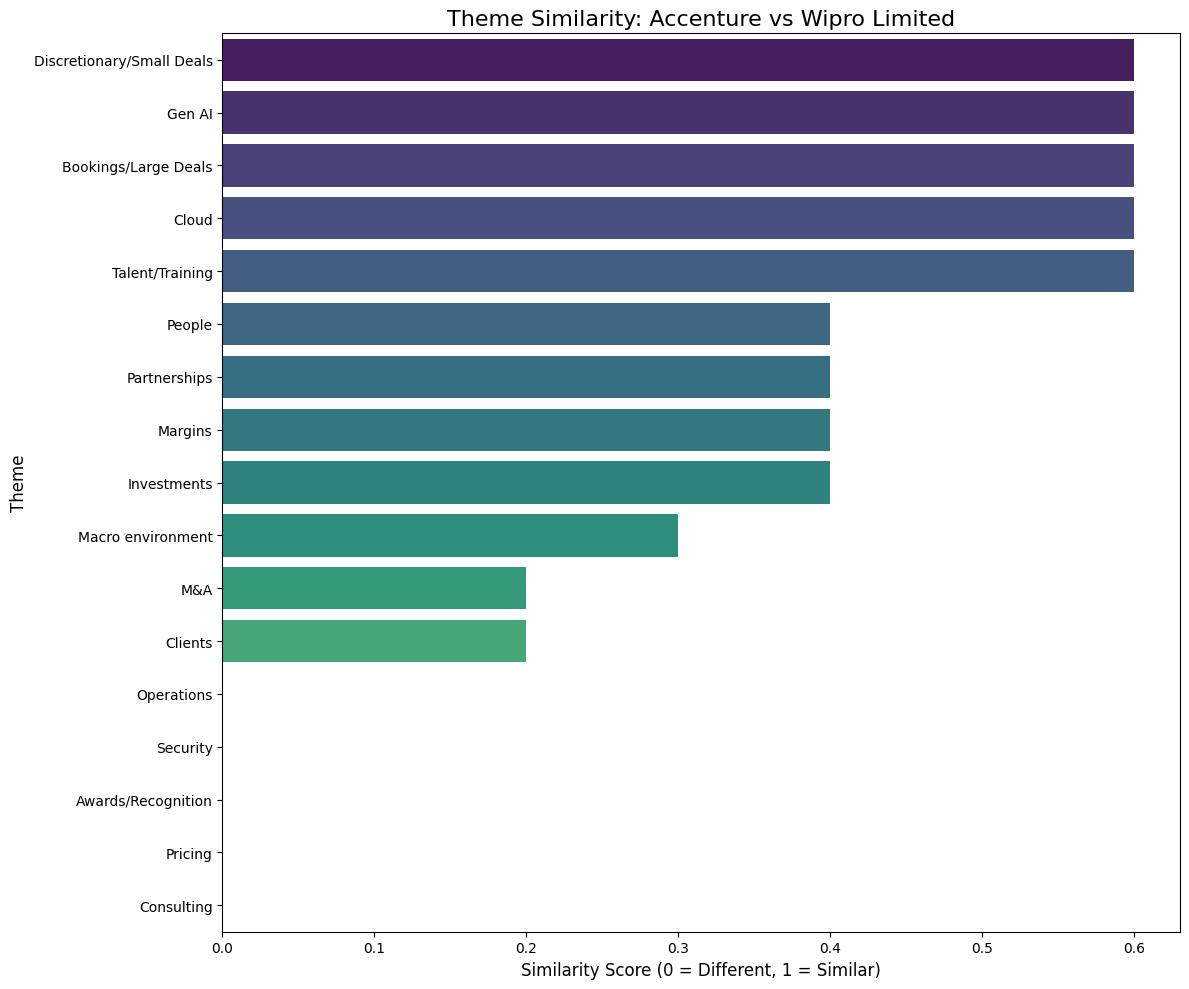

<Figure size 1400x1000 with 0 Axes>

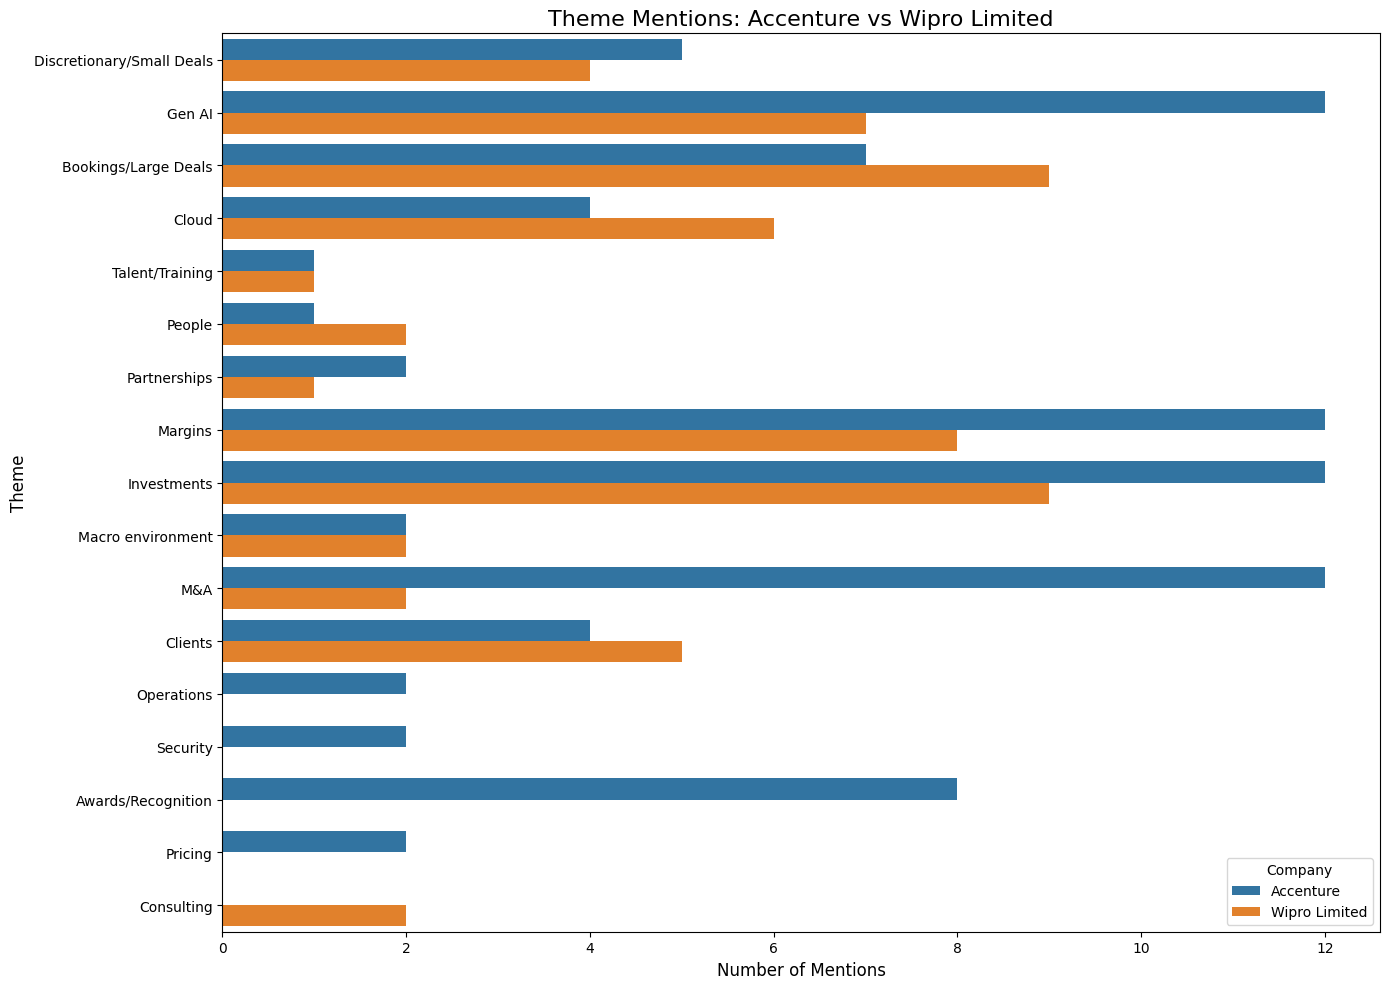

In [9]:
# Example usage for Google Colab
import os
accenture_file = '/content/sample_data/Acc_verbatim_analysis_20250305_093958_final.json'
wipro_file = '/content/sample_data/wipro__verbatim_analysis_20250305_095829_final.json'

# Get OpenAI API key - optional, will use basic analysis if not provided
api_key =  'sk-proj-'

# # Choose model if API key is provided
model = "gpt-3.5-turbo"

#Run comparison
result = run_comparison(accenture_file, wipro_file, api_key, model)

# Display summary
display(result["results"]["summary_df"].sort_values("Similarity Score", ascending=False))


In [17]:
# Strategic Earnings Transcript Theme Comparator, md file based

# Colab Setup and Dependency Installation
!pip install openai pandas matplotlib seaborn

# Import required libraries
import json
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict
import numpy as np
from IPython.display import Markdown, display, HTML, Image
from google.colab import files
import shutil
from openai import OpenAI

class StrategicThemeComparator:
    def __init__(self, api_key, model="gpt-3.5-turbo"):
        """
        Initialize the strategic theme comparator with LLM enhancement

        Parameters:
        -----------
        api_key : str
            OpenAI API key
        model : str
            Model to use ("gpt-3.5-turbo" or "gpt-4o-mini")
        """
        # Predefined themes list
        self.themes = [
            "Macro environment", "Pricing", "Margins", "Bookings/Large Deals",
            "Discretionary/Small Deals", "People", "Cloud", "Security", "Gen AI",
            "M&A", "Investments", "Partnerships", "Technology Budget",
            "Product/IP/Assets", "Talent/Training", "Clients", "Awards/Recognition"
        ]

        # Initialize OpenAI client
        try:
            self.client = OpenAI(api_key=api_key)
            self.model = model
            print(f"Strategic Theme Comparator initialized with {model}")
        except Exception as e:
            raise Exception(f"Error initializing OpenAI client: {e}")

    def load_transcript_data(self, file_path):
        """
        Load transcript data using LLM-based extraction

        Args:
            file_path (str): Path to the file containing transcript data

        Returns:
            dict: A dictionary containing company name, filename, and themes data
        """
        try:
            # Open and read the file
            with open(file_path, 'r', encoding='utf-8') as f:
                file_content = f.read().strip()

            # Check if file is empty
            if not file_content:
                raise ValueError(f"File is empty: {file_path}")

            # Try JSON parsing first
            try:
                data = json.loads(file_content)
                return self._process_json_data(data, file_path)
            except json.JSONDecodeError:
                # If not JSON, use LLM for Markdown extraction
                return self._extract_markdown_with_llm(file_content, file_path)

        except (IOError, Exception) as e:
            # Handle file reading or parsing errors
            print(f"Error reading file {file_path}: {e}")
            return None

    def _extract_markdown_with_llm(self, file_content, file_path, model="gpt-3.5-turbo"):
        """
        Extract structured data from Markdown using LLM
        """
        # Prompt for LLM-based extraction
        prompt = f"""Extract structured data from this earnings call transcript markdown document.

Input Document:
{file_content[:10000]}  # Limit initial context to prevent token overflow

Please extract the following structured information:

1. Company Name: Identify the primary company discussed in the document
2. Themes: Extract all distinct themes mentioned
3. Theme Details: For each theme, capture:
   - Number of mentions
   - Key verbatim quotes (with page numbers)
   - Any strategic insights or metrics

Output Format (STRICT JSON):
{{
    "company_name": "Company Name",
    "filename": "original_filename.md",
    "themes_data": {{
        "Theme Name 1": [
            {{
                "quote": "Exact verbatim quote",
                "page": 1,
                "strategic_context": "Brief strategic insight"
            }},
            ...
        ],
        "Theme Name 2": [
            ...
        ]
    }}
}}

Guidelines:
- Be precise in extracting quotes
- Preserve exact wording
- Include page numbers
- Only include themes with at least one substantive quote
- Capture strategic context where possible
"""

        # Retry mechanism for API call
        max_retries = 3
        for attempt in range(max_retries):
            try:
                response = self.client.chat.completions.create(
                    model=model,
                    messages=[
                        {
                            "role": "system",
                            "content": "You are an expert financial analyst extracting structured data from earnings call transcripts."
                        },
                        {
                            "role": "user",
                            "content": prompt
                        }
                    ],
                    response_format={"type": "json_object"},
                    temperature=0.3,
                    max_tokens=4000
                )

                # Parse the response
                result = json.loads(response.choices[0].message.content)

                # Validate the extracted data
                if not result.get("company_name"):
                    # Fallback to filename-based company name
                    result["company_name"] = os.path.basename(file_path).split('_')[0]

                # Ensure filename is set
                result["filename"] = os.path.basename(file_path)

                return result

            except Exception as e:
                if attempt < max_retries - 1:
                    print(f"LLM extraction attempt {attempt + 1} failed: {e}")
                    time.sleep(2 ** attempt)  # Exponential backoff
                else:
                    # Fallback to manual extraction if all attempts fail
                    return self._fallback_markdown_extraction(file_content, file_path)

    def _fallback_markdown_extraction(self, file_content, file_path):
        """
        Fallback method for extracting data from Markdown if LLM fails
        """
        # Basic regex-based extraction
        # Try to extract company name from first heading
        company_match = re.search(r'#\s*([^-\n]+)', file_content)
        company_name = company_match.group(1).strip() if company_match else os.path.basename(file_path).split('_')[0]

        # Extract themes and quotes using regex
        themes_data = {}
        theme_pattern = re.compile(r'# (.*?)\n\n## Summary\nThis theme appears in (\d+) verbatim quotes throughout the.*?\n\n(.*?)(?=\n# |$)', re.DOTALL)

        for match in theme_pattern.finditer(file_content):
            theme = match.group(1).strip()
            quotes_content = match.group(3).strip()

            # Extract verbatim quotes
            quote_pattern = re.compile(r'- "([^"]+)" \(Page (\d+)\)')
            quotes = [
                {
                    "quote": quote.group(1),
                    "page": int(quote.group(2)),
                    "strategic_context": ""  # No strategic context in fallback method
                }
                for quote in quote_pattern.finditer(quotes_content)
            ]

            # Only add themes with quotes
            if quotes:
                themes_data[theme] = quotes

        return {
            "company_name": company_name,
            "filename": os.path.basename(file_path),
            "themes_data": themes_data
        }

    def _process_json_data(self, data, file_path):
        """
        Process data from a JSON file
        """
        # Try to extract company name from metadata
        company_name = data.get("metadata", {}).get("company_name")

        # If not found in metadata, extract from filename
        if not company_name:
            filename = os.path.basename(file_path).lower()

            # Dictionary of company name mappings
            company_mappings = {
                "accenture": "Accenture",
                "wipro": "Wipro Limited",
                "tcs": "Tata Consultancy Services",
                "tata": "Tata Consultancy Services",
                "infosys": "Infosys",
                "cognizant": "Cognizant",
                "hcl": "HCL Technologies"
            }

            # Find matching company name
            for keyword, company in company_mappings.items():
                if keyword in filename:
                    company_name = company
                    break

            # If no specific company detected, use generic name
            if not company_name:
                company_name = "Company " + filename.split('_')[0]

        # Extract aggregated quotes by theme
        themes_data = {
            theme: [
                {
                    "quote": quote,
                    "page": 1,  # Default page number if not specified
                    "strategic_context": ""
                } for quote in quotes
            ]
            for theme, quotes in data.get("aggregated_verbatim_quotes", {}).items()
            if quotes  # Only include themes with non-empty quotes
        }

        return {
            "company_name": company_name,
            "filename": os.path.basename(file_path),
            "themes_data": themes_data
        }

    def calculate_llm_similarity(self, theme, company1_name, company2_name, company1_quotes, company2_quotes):
        """
        Use LLM to calculate a similarity score with strategic reasoning
        """
        if not company1_quotes or not company2_quotes:
            return 0.0, "One company has no quotes on this theme"

        # Prepare quotes for prompt (all quotes to preserve context)
        c1_quotes_str = "\n".join([f"- \"{q['quote']}\" (Page {q['page']})" for q in company1_quotes])
        c2_quotes_str = "\n".join([f"- \"{q['quote']}\" (Page {q['page']})" for q in company2_quotes])

        prompt = f"""As a strategy analyst with 15+ years experience in technology consulting, analyze the similarity between how {company1_name} and {company2_name} approach the "{theme}" theme in their earnings calls.

{company1_name} quotes:
{c1_quotes_str}

{company2_name} quotes:
{c2_quotes_str}

Calculate a strategic similarity score between 0.0 and 1.0 where:
- 0.0 means fundamentally different strategic approaches, metrics, priorities, or market positions
- 0.5 means similar high-level strategy but different implementation tactics, metrics, or emphases
- 1.0 means identical strategic positioning, priorities, metrics, and execution approach

Consider:
1. Strategic focus areas and priorities
2. Investment levels and resource allocation
3. Market positioning and competitive differentiation
4. Metrics used to measure success
5. Future outlook and growth strategy

Format your response as JSON:
{{
    "similarity_score": X.X,
    "strategic_reasoning": "Detailed strategic assessment of similarities and differences (3-4 sentences)"
}}
"""

        # Call API with retry logic
        max_retries = 3
        for attempt in range(max_retries):
            try:
                response = self.client.chat.completions.create(
                    model=self.model,
                    messages=[
                        {"role": "system", "content": "You are a senior strategy analyst with 15+ years experience in technology consulting, specialized in comparing enterprise technology companies."},
                        {"role": "user", "content": prompt}
                    ],
                    temperature=0.3,
                    response_format={"type": "json_object"},
                    max_tokens=500
                )

                result = json.loads(response.choices[0].message.content)
                score = float(result.get("similarity_score", 0.5))
                reasoning = result.get("strategic_reasoning", "No strategic assessment provided")

                return score, reasoning
            except Exception as e:
                if attempt < max_retries - 1:
                    print(f"API error, retrying ({attempt+1}/{max_retries}): {e}")
                    time.sleep(2 ** attempt)  # Exponential backoff
                else:
                    print(f"API error after {max_retries} attempts: {e}")
                    # Return a placeholder score with error message
                    return 0.5, f"Error calculating similarity: {str(e)}"

    def generate_strategic_comparison(self, theme, company1_name, company2_name, company1_quotes, company2_quotes, similarity_score, reasoning):
        """
        Generate a comprehensive strategic comparison using LLM

        Args:
            theme (str): Strategic theme being analyzed
            company1_name (str): Name of first company
            company2_name (str): Name of second company
            company1_quotes (list): Quotes from first company
            company2_quotes (list): Quotes from second company
            similarity_score (float): Calculated similarity score
            reasoning (str): Strategic reasoning for similarity

        Returns:
            str: Markdown-formatted strategic comparison
        """
        # Preserve all verbatim quotes with page references
        c1_quotes_str = "\n".join([f"- \"{q['quote']}\" (Page {q['page']})" for q in company1_quotes])
        c2_quotes_str = "\n".join([f"- \"{q['quote']}\" (Page {q['page']})" for q in company2_quotes])

        if not c1_quotes_str:
            c1_quotes_str = "No quotes available from this company on this theme."

        if not c2_quotes_str:
            c2_quotes_str = "No quotes available from this company on this theme."

        prompt = f"""As a strategy analyst with 15+ years of experience in the technology consulting sector, create a comprehensive strategic comparison of how {company1_name} and {company2_name} approach the "{theme}" theme.

    {company1_name} verbatim quotes:
    {c1_quotes_str}

    {company2_name} verbatim quotes:
    {c2_quotes_str}

    Similarity Score: {similarity_score:.2f}
    Strategic Assessment: {reasoning}

    Create a detailed strategic analysis that ALWAYS maintains and references the exact verbatim quotes with their page numbers. Your analysis must include:

    1. Strategic positioning of each company on this theme
    2. Key differentiators and competitive advantages
    3. Investment priorities and resource allocation differences
    4. Implications for market share and customer acquisition
    5. Long-term strategic implications for each company

    Format your analysis in markdown with these sections:
    # {theme} Strategic Comparison: {company1_name} vs {company2_name}

    ## Strategic Similarity Score: {similarity_score:.2f}
    [Include your strategic assessment]

    ## {company1_name}'s Strategic Positioning
    [Analyze their approach with specific verbatim quote references and page numbers]

    ## {company2_name}'s Strategic Positioning
    [Analyze their approach with specific verbatim quote references and page numbers]

    ## Strategic Differentiators
    [Identify key strategic differences with references to specific metrics, statements, or positioning from the verbatim quotes]

    ## Competitive Implications
    [Analyze what these differences mean for competitive positioning, market share, and long-term success]

    IMPORTANT REQUIREMENTS:
    1. ALWAYS use verbatim quotes with page numbers as evidence for your analysis
    2. Don't summarize or paraphrase quotes - use them exactly as provided
    3. Ground ALL strategic insights in specific verbatim statements
    4. Focus on strategic implications rather than tactical details
    5. If data is limited for either company, explicitly acknowledge this limitation
    """

        # Call API with retry logic
        max_retries = 3
        for attempt in range(max_retries):
            try:
                response = self.client.chat.completions.create(
                    model=self.model,
                    messages=[
                        {
                            "role": "system",
                            "content": "You are a senior strategy analyst with 15+ years of experience in technology consulting, specialized in analyzing enterprise technology companies. You always ground your analysis in specific verbatim quotes with their source references."
                        },
                        {
                            "role": "user",
                            "content": prompt
                        }
                    ],
                    temperature=0.4,
                    max_tokens=2000
                )

                analysis = response.choices[0].message.content
                return analysis

            except Exception as e:
                if attempt < max_retries - 1:
                    print(f"API error, retrying ({attempt+1}/{max_retries}): {e}")
                    time.sleep(2 ** attempt)  # Exponential backoff
                else:
                    # Fallback to manual comparison if LLM fails
                    return self._generate_fallback_comparison(
                        theme, company1_name, company2_name,
                        company1_quotes, company2_quotes,
                        similarity_score, reasoning
                    )

    def _generate_fallback_comparison(self, theme, company1_name, company2_name,
                                      company1_quotes, company2_quotes,
                                      similarity_score, reasoning):
        """
        Generate a basic comparison without LLM when API fails

        Args:
            theme (str): Strategic theme being analyzed
            company1_name (str): Name of first company
            company2_name (str): Name of second company
            company1_quotes (list): Quotes from first company
            company2_quotes (list): Quotes from second company
            similarity_score (float): Calculated similarity score
            reasoning (str): Strategic reasoning for similarity

        Returns:
            str: Markdown-formatted basic comparison
        """
        comparison_text = f"# {theme} Strategic Comparison: {company1_name} vs {company2_name}\n\n"
        comparison_text += f"## Strategic Similarity Score: {similarity_score:.2f}\n"
        comparison_text += f"{reasoning}\n\n"

        # Add company 1 section with all verbatim quotes
        comparison_text += f"## {company1_name}'s Strategic Positioning\n"
        if company1_quotes:
            for quote in company1_quotes:
                comparison_text += f"- \"{quote['quote']}\" (Page {quote['page']})\n"
        else:
            comparison_text += f"No quotes found from {company1_name} on this theme.\n"

        comparison_text += "\n"

        # Add company 2 section with all verbatim quotes
        comparison_text += f"## {company2_name}'s Strategic Positioning\n"
        if company2_quotes:
            for quote in company2_quotes:
                comparison_text += f"- \"{quote['quote']}\" (Page {quote['page']})\n"
        else:
            comparison_text += f"No quotes found from {company2_name} on this theme.\n"

        comparison_text += "\n"

        # Add strategic differentiators section
        comparison_text += "## Strategic Differentiators\n"
        if not company1_quotes and not company2_quotes:
            comparison_text += "Neither company discussed this theme sufficiently for strategic analysis.\n"
        elif not company1_quotes:
            comparison_text += f"Only {company2_name} has articulated a strategic position on this theme.\n"
        elif not company2_quotes:
            comparison_text += f"Only {company1_name} has articulated a strategic position on this theme.\n"
        else:
            comparison_text += "Strategic differentiators require further analysis based on the verbatim quotes above.\n"

        comparison_text += "\n## Competitive Implications\n"
        comparison_text += "Further analysis required to determine competitive implications based on the verbatim evidence.\n"

        return comparison_text

    def compare_companies(self, company1_data, company2_data):
        """
        Compare companies based on their transcript data with strategic focus

        Args:
            company1_data (dict): Data for first company
            company2_data (dict): Data for second company

        Returns:
            dict: Comparison results including comparisons and summary
        """
        company1_name = company1_data["company_name"]
        company2_name = company2_data["company_name"]

        print(f"Strategically comparing {company1_name} with {company2_name}")

        # Find all unique themes
        all_themes = set(company1_data["themes_data"].keys()).union(
            set(company2_data["themes_data"].keys())
        )

        comparisons = {}
        summary_data = []

        # Analyze each theme
        for theme in all_themes:
            print(f"Strategically analyzing theme: {theme}")
            company1_quotes = company1_data["themes_data"].get(theme, [])
            company2_quotes = company2_data["themes_data"].get(theme, [])

            # Calculate similarity score using LLM
            similarity_score, reasoning = self.calculate_llm_similarity(
                theme, company1_name, company2_name,
                company1_quotes, company2_quotes
            )

            # Generate strategic comparison
            comparison = self.generate_strategic_comparison(
                theme, company1_name, company2_name,
                company1_quotes, company2_quotes,
                similarity_score, reasoning
            )

            comparisons[theme] = comparison

            # Add to summary data
            summary_data.append({
                "Theme": theme,
                "Strategic Similarity": similarity_score,
                f"{company1_name} Mentions": len(company1_quotes),
                f"{company2_name} Mentions": len(company2_quotes),
                "Strategic Assessment": reasoning
            })

        # Create summary dataframe
        summary_df = pd.DataFrame(summary_data)

        return {
            "comparisons": comparisons,
            "summary_df": summary_df
        }


def create_visualizations(summary_df, company1_name, company2_name, output_dir="."):
    """
    Create visualizations comparing the companies

    Args:
        summary_df (pandas.DataFrame): Summary of strategic comparisons
        company1_name (str): Name of first company
        company2_name (str): Name of second company
        output_dir (str, optional): Directory to save visualizations

    Returns:
        pandas.DataFrame: Sorted summary dataframe
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Sort by similarity score
    sorted_df = summary_df.sort_values("Strategic Similarity", ascending=False)

    # 1. Create similarity score visualization
    plt.figure(figsize=(12, 10))
    ax = sns.barplot(
        x="Strategic Similarity",
        y="Theme",
        data=sorted_df,
        palette="viridis"
    )
    plt.title(f"Strategic Theme Similarity: {company1_name} vs {company2_name}", fontsize=16)
    plt.xlabel("Strategic Similarity Score (0 = Different, 1 = Similar)", fontsize=12)
    plt.ylabel("Theme", fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "strategic_similarity_scores.png"), dpi=300)
    plt.close()

    # 2. Create mentions comparison visualization
    # Create data for grouped bar chart
    mentions_data = []
    for _, row in sorted_df.iterrows():
        mentions_data.append({
            "Theme": row["Theme"],
            "Company": company1_name,
            "Mentions": row[f"{company1_name} Mentions"]
        })
        mentions_data.append({
            "Theme": row["Theme"],
            "Company": company2_name,
            "Mentions": row[f"{company2_name} Mentions"]
        })

    mentions_df = pd.DataFrame(mentions_data)

    # Sort by themes in similarity order
    theme_order = sorted_df["Theme"].tolist()
    mentions_df["Theme"] = pd.Categorical(mentions_df["Theme"], categories=theme_order, ordered=True)

    # Create the grouped bar chart
    plt.figure(figsize=(14, 10))
    sns.barplot(
        x="Mentions",
        y="Theme",
        hue="Company",
        data=mentions_df.sort_values("Theme"),
        palette=["#1f77b4", "#ff7f0e"]
    )

    plt.title(f"Theme Strategic Focus: {company1_name} vs {company2_name}", fontsize=16)
    plt.xlabel("Number of Strategic Mentions", fontsize=12)
    plt.ylabel("Theme", fontsize=12)
    plt.legend(title="Company")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "theme_strategic_focus.png"), dpi=300)
    plt.close()

    return sorted_df

def run_strategic_comparison(source_file, target_file, api_key, model="gpt-3.5-turbo",
                             source_company=None, target_company=None):
    """
    Run the strategic comparison between two companies

    Args:
        source_file (str): Path to the source company file
        target_file (str): Path to the target company file
        api_key (str): OpenAI API key
        model (str, optional): LLM model to use
        source_company (str, optional): Override source company name
        target_company (str, optional): Override target company name

    Returns:
        dict: Comparison results with output directories and analysis
    """
    # Initialize comparator
    comparator = StrategicThemeComparator(api_key=api_key, model=model)

    # Load transcript data
    print("Loading source company data...")
    source_data = comparator.load_transcript_data(source_file)

    print("Loading target company data...")
    target_data = comparator.load_transcript_data(target_file)

    # Override company names if provided
    if source_company:
        source_data["company_name"] = source_company

    if target_company:
        target_data["company_name"] = target_company

    # Create output directory
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    output_dir = f"{source_data['company_name'].replace(' ', '_')}_vs_{target_data['company_name'].replace(' ', '_')}_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)

    print(f"Comparing {source_data['company_name']} (source) with {target_data['company_name']} (target)...")

    # Run comparison
    results = comparator.compare_companies(source_data, target_data)

    # Create visualizations
    print("Creating strategic visualizations...")
    sorted_df = create_visualizations(
        results["summary_df"],
        source_data["company_name"],
        target_data["company_name"],
        output_dir
    )

    # Save summary to CSV
    summary_file = os.path.join(output_dir, "strategic_comparison_summary.csv")
    sorted_df.to_csv(summary_file, index=False)
    print(f"Saved strategic summary to: {summary_file}")

    for theme, comparison in results["comparisons"].items():
        theme_file = os.path.join(output_dir, f"{theme.replace('/', '_')}_strategic_comparison.md")
        with open(theme_file, 'w', encoding='utf-8') as f:
            f.write(comparison)
        print(f"Saved strategic comparison for {theme} to: {theme_file}")

    # Create combined file with all strategic comparisons
    combined_file = os.path.join(output_dir, "all_strategic_comparisons.md")
    with open(combined_file, 'w', encoding='utf-8') as f:
        # Write header
        f.write(f"# Strategic Theme Comparisons: {source_data['company_name']} vs {target_data['company_name']}\n\n")
        f.write(f"## Comparison Overview\n")
        f.write(f"- **Source Company**: {source_data['company_name']}\n")
        f.write(f"- **Target Company**: {target_data['company_name']}\n")
        f.write(f"- **Comparison Date**: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"- **Total Themes Analyzed**: {len(results['comparisons'])}\n\n")

        # Add summary table
        f.write("## Strategic Similarity Summary\n\n")
        f.write("| Theme | Similarity Score | Strategic Assessment |\n")
        f.write("|-------|-----------------|----------------------|\n")
        for _, row in sorted_df.iterrows():
            f.write(f"| {row['Theme']} | {row['Strategic Similarity']:.2f} | {row['Strategic Assessment']} |\n")

        f.write("\n---\n\n")

        # Add detailed comparisons for each theme
        for theme in sorted_df["Theme"]:
            if theme in results["comparisons"]:
                f.write(results["comparisons"][theme])
                f.write("\n\n---\n\n")

    print(f"Saved all strategic comparisons to: {combined_file}")

    # Create README with instructions and overview
    readme_file = os.path.join(output_dir, "README.md")
    with open(readme_file, 'w', encoding='utf-8') as f:
        f.write(f"# Strategic Comparison: {source_data['company_name']} vs {target_data['company_name']}\n\n")
        f.write("## Overview\n")
        f.write("This directory contains a comprehensive strategic comparison between two companies based on their earnings call transcripts.\n\n")
        f.write("## Files in this Directory\n")
        f.write("- `strategic_comparison_summary.csv`: Quantitative summary of strategic similarities\n")
        f.write("- `strategic_similarity_scores.png`: Visualization of theme similarity scores\n")
        f.write("- `theme_strategic_focus.png`: Comparison of theme mentions\n")
        f.write("- `all_strategic_comparisons.md`: Detailed markdown report of all theme comparisons\n")
        f.write("- Individual theme comparison markdown files\n\n")
        f.write("## Methodology\n")
        f.write("- Themes were extracted from earnings call transcripts\n")
        f.write("- Strategic similarity calculated using AI-powered analysis\n")
        f.write("- Comparisons ground insights in verbatim quotes\n")

    print(f"Saved README to: {readme_file}")

    return {
        "output_dir": output_dir,
        "results": results,
        "source_data": source_data,
        "target_data": target_data,
        "summary_file": summary_file,
        "combined_file": combined_file,
        "readme_file": readme_file
    }



In [21]:
#md file comparator
def main():
    """
    Main function to run strategic comparison with user inputs
    """
    # Prompt for OpenAI API Key
    api_key = 'sk-proj-'

    # Upload source and target files
    print("Please upload the source company transcript file.")
    source_files = files.upload()
    source_file = list(source_files.keys())[0]

    print("Please upload the target company transcript file.")
    target_files = files.upload()
    target_file = list(target_files.keys())[0]

    # Optional: Allow users to specify company names
    source_company = input("Enter source company name (optional, press Enter to skip): ").strip() or None
    target_company = input("Enter target company name (optional, press Enter to skip): ").strip() or None

    # Run comparison
    try:
        results = run_strategic_comparison(
            source_file,
            target_file,
            api_key,
            source_company=source_company,
            target_company=target_company
        )

        print("\n--- Comparison Complete ---")
        print(f"Output Directory: {results['output_dir']}")
        print("Files generated:")
        for key, value in results.items():
            if key.endswith('_file'):
                print(f"- {key}: {value}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Run the main function when the script is executed
if __name__ == '__main__':
    main()

Please upload the source company transcript file.


Saving Acc_all_theme_analyses.md to Acc_all_theme_analyses (5).md
Please upload the target company transcript file.


Saving Wipro_all_theme_analyses.md to Wipro_all_theme_analyses (4).md
Enter source company name (optional, press Enter to skip): 
Enter target company name (optional, press Enter to skip): 
Strategic Theme Comparator initialized with gpt-3.5-turbo
Loading source company data...
Loading target company data...
Comparing Accenture (source) with Wipro Limited (target)...
Strategically comparing Accenture with Wipro Limited
Strategically analyzing theme: Margins
Strategically analyzing theme: Gen AI
Strategically analyzing theme: Investments
Strategically analyzing theme: Bookings/Large Deals
Strategically analyzing theme: Cloud
Strategically analyzing theme: Talent/Training
Strategically analyzing theme: Discretionary/Small Deals
Creating strategic visualizations...


<ipython-input-17-7f16740991ed>:573: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Saved strategic summary to: Accenture_vs_Wipro_Limited_20250305_141053/strategic_comparison_summary.csv
Saved strategic comparison for Margins to: Accenture_vs_Wipro_Limited_20250305_141053/Margins_strategic_comparison.md
Saved strategic comparison for Gen AI to: Accenture_vs_Wipro_Limited_20250305_141053/Gen AI_strategic_comparison.md
Saved strategic comparison for Investments to: Accenture_vs_Wipro_Limited_20250305_141053/Investments_strategic_comparison.md
Saved strategic comparison for Bookings/Large Deals to: Accenture_vs_Wipro_Limited_20250305_141053/Bookings_Large Deals_strategic_comparison.md
Saved strategic comparison for Cloud to: Accenture_vs_Wipro_Limited_20250305_141053/Cloud_strategic_comparison.md
Saved strategic comparison for Talent/Training to: Accenture_vs_Wipro_Limited_20250305_141053/Talent_Training_strategic_comparison.md
Saved strategic comparison for Discretionary/Small Deals to: Accenture_vs_Wipro_Limited_20250305_141053/Discretionary_Small Deals_strategic_comp